In [22]:
# !wget -nc https://huggingface.co/datasets/ylecun/mnist/resolve/main/mnist/test-00000-of-00001.parquet
# !wget -nc https://huggingface.co/datasets/ylecun/mnist/resolve/main/mnist/train-00000-of-00001.parquet

In [1]:
import pandas as pd 

test_file_path = 'content/test-00000-of-00001.parquet'
train_file_path = 'content/train-00000-of-00001.parquet'

mnist_train_df = pd.read_parquet(train_file_path)
minst_test_df = pd.read_parquet(test_file_path)

In [2]:
import io
from PIL import Image
import numpy as np


class Dataset:
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return convert_to_numpy(self.df.iloc[index])


def convert_to_numpy(data_dict):
    png_bytes = data_dict['image']['bytes']
    image = Image.open(io.BytesIO(png_bytes))
    image_array = np.array(image, dtype=np.float32) / 255.0
    label_array = np.array(data_dict['label'])
    return {'image':image_array[:,:,np.newaxis], 'label':label_array}

In [3]:
import grain

batch_size = 256

mnist_train = Dataset(mnist_train_df)
mnist_test = Dataset(mnist_train_df)

sampler = grain.samplers.SequentialSampler(
    num_records=len(mnist_train),
    shard_options=grain.sharding.NoSharding())

train_dl = grain.DataLoader(
    data_source=mnist_train,
    sampler=sampler,
    operations=[grain.transforms.Batch(batch_size=batch_size, drop_remainder=True)]
)

test_dl = grain.DataLoader(
    data_source=mnist_test,
    sampler=sampler,
    operations=[grain.transforms.Batch(batch_size=batch_size, drop_remainder=True)]
)

In [4]:
from flax import nnx
from functools import partial

class CNN(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3,3), rngs=rngs)
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3,3), rngs=rngs)
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2,2), strides=(2,2))
        self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
        self.linear2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x):
        x = self.avg_pool(nnx.relu(self.conv1(x)))
        x = self.avg_pool(nnx.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1) # flatten
        x = nnx.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
model = CNN(rngs=nnx.Rngs(0))

nnx.display(model)

In [5]:
import jax.numpy as jnp

y = model(jnp.ones((1,28,28,1)))
y

Array([[ 0.1840561 ,  0.5048597 ,  0.20095994,  0.48739707, -0.3791524 ,
        -0.5551923 , -0.544814  , -0.04560187,  0.05879361,  0.13339692]],      dtype=float32)

In [6]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [7]:
def loss_fn(model: CNN, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label']) # In-place updates.
    optimizer.update(model, grads) # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label']) # In-place updates.


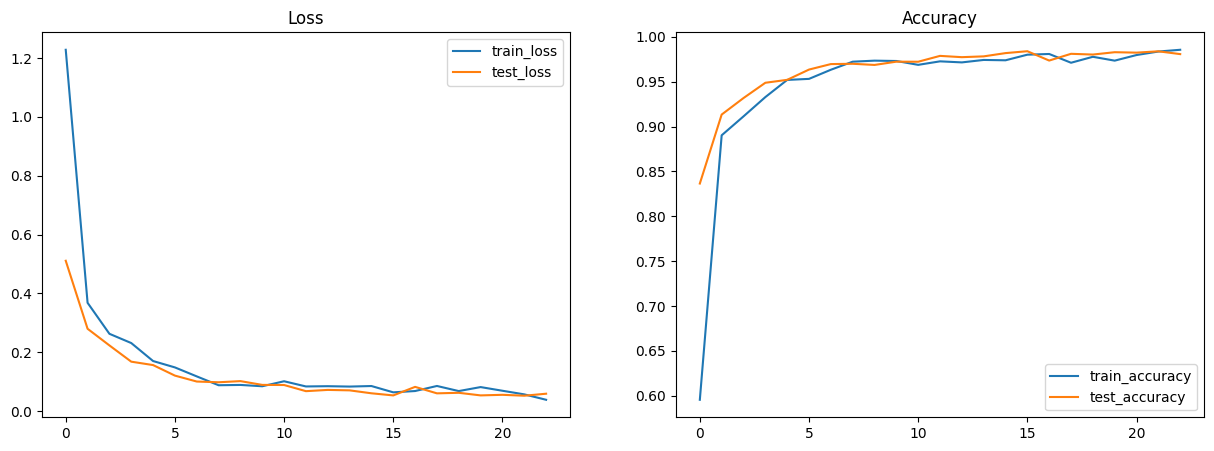

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

eval_every = 10
train_steps = 1000
metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

rngs = nnx.Rngs(0)

for step, batch in enumerate(train_dl):
    model.train()
    train_step(model, optimizer, metrics, batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):
        for metric, value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        model.eval()
        for test_batch in test_dl:
            eval_step(model, metrics, test_batch)

        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()

        clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
        ax1.legend()
        ax2.legend()
        plt.show()



In [9]:
model.eval()

@nnx.jit
def pred_step(model: CNN, batch):
    logits = model(batch['image'])
    return logits.argmax(axis=1)

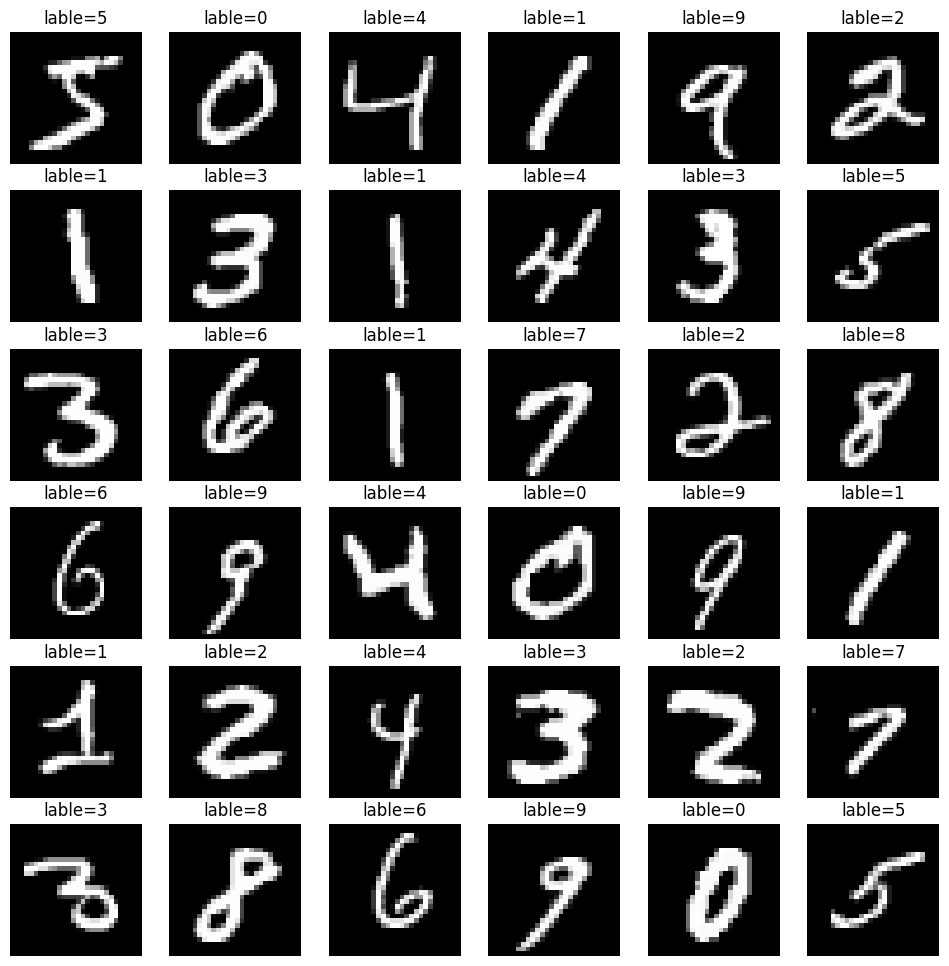

In [10]:
test_dl_iter = iter(test_dl)
test_batch = next(test_dl_iter)

pred = pred_step(model, test_batch)

fig, axs = plt.subplots(6,6, figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ... , 0], cmap='gray')
    ax.set_title(f'lable={pred[i]}')
    ax.axis('off')